# Stock predictions with state-of-the-art Transformer and Time Embeddings

LSTM (Long-Short Term Memory Models) and CNN (Convolutional Neural Network) have its limitations for large datasets. In recent years Transformers have gained popularity due to their outstanding performance. Combining the self-attention mechanism, parallelization, and positional encoding under one hood provides usually an edge over classical LSTM and CNN models when working on tasks where semantic feature extraction and large datasets are required.

- [1] Why Self-Attention? A Targeted Evaluation of Neural Machine Translation Architectures https://arxiv.org/abs/1808.08946

This notebook demonstrates a Transformer implementation customized for time-series sequences that have multiple features e.g. the (Open, High, Low, Close, Volume) features of our stock data. This Transformer architecture uses Time Embeddings.

- Jan Schmitz: Stock predictions with state-of-the-art Transformer and Time Embeddings 
    - https://towardsdatascience.com/stock-predictions-with-state-of-the-art-transformer-and-time-embeddings-3a4485237de6
    - https://github.com/JanSchm/CapMarket/blob/master/bot_experiments/IBM_Transformer%2BTimeEmbedding.ipynb

In [1]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

Tensorflow version: 2.4.1


## Hyperparameters

In [2]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Data
For the explanatory purpose of this notebook, we will be using the GOOG stock price history. The GOOG dataset starts on the 2010-04-01, ends on the date 2021-09-02. Additionally, for every training day, we have the Open, High, Low, and Close price as well as the trading Volume (OHLCV) of the GOOG stock.

In [3]:
path = '../dataset/GOOG.csv'
df = pd.read_csv(path,usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
2790,2021-02-03,2073.000000,2116.500000,2018.380005,2070.070068,4118200
2791,2021-02-04,2068.889893,2078.550049,2042.589966,2062.370117,1852300
2792,2021-02-05,2070.000000,2102.510010,2059.330078,2098.000000,1533900
2793,2021-02-08,2105.909912,2123.547119,2072.000000,2092.909912,1241900
2794,2021-02-09,2078.540039,2105.129883,2078.540039,2083.510010,888100


As we can see, the ‘Date’ column is not in appropriate format. Pandas has inbuilt features to deal with time-series data in a smarter way. But to make use of Pandas functionality for dates, we need to ensure that the ‘Date’ column is of type ‘datetime64(ns)’.

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [5]:
df['Date'].min()

Timestamp('2010-01-04 00:00:00')

In [6]:
df['Date'].max()

Timestamp('2021-02-09 00:00:00')

In [7]:
df['Date'].max() - df['Date'].min()

Timedelta('4054 days 00:00:00')

The total time duration for which we’re carrying out this analysis is 1416 trading days.

In [8]:
df.iloc[-90:].describe().astype(int)

,Open,High,Low,Close,Volume
count,90,90,90,90,90
mean,1736,1759,1719,1739,1692637
std,141,142,139,141,685054
min,1462,1468,1436,1453,346800
25%,1641,1668,1617,1643,1246975
50%,1753,1772,1739,1753,1523700
75%,1787,1816,1768,1792,1920950
max,2105,2123,2078,2098,4329100


In last 90 days, the average closing price for GOOG stock was about 1492. 
For about 75% of time the stock was trading below 1531 and it clocked maximum of 1728. The maximum volume of shares traded on a single day was 4267700 with median quantity being 1623100.

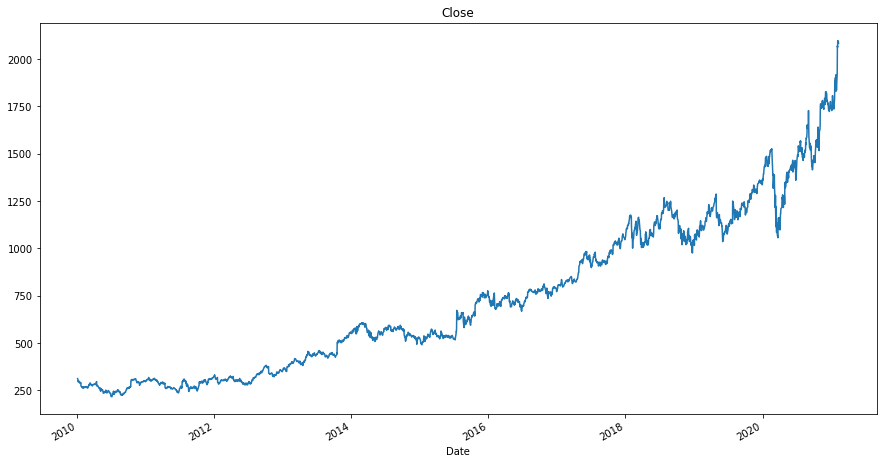

In [9]:
df.index = df['Date']
df['Close'].plot(figsize = (15,8), title='Close')
plt.show()

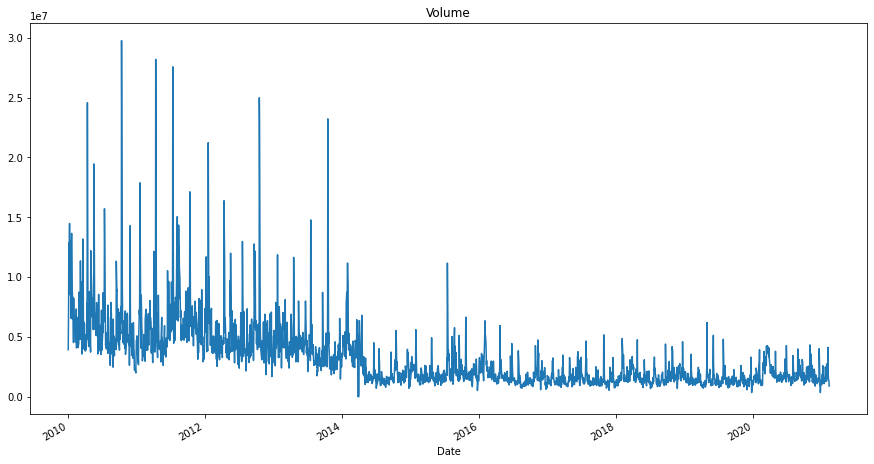

In [10]:
df['Volume'].plot(figsize = (15,8), title='Volume')
plt.show()

Volume is not adjusted for Stock divide

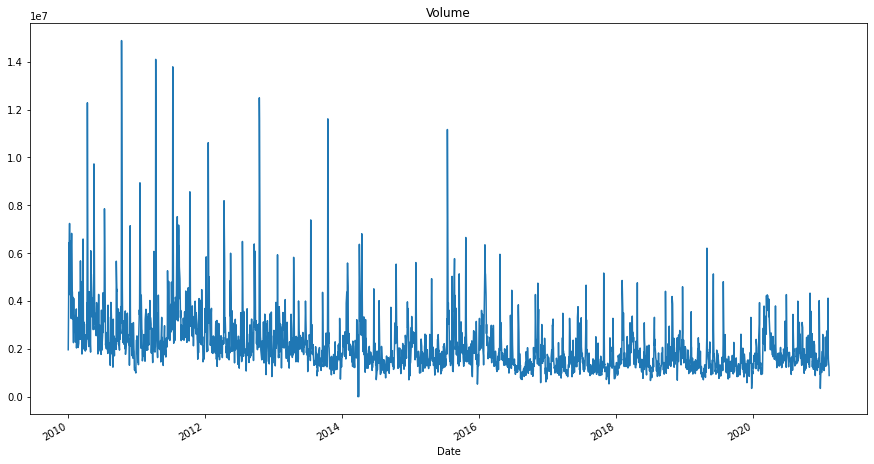

In [11]:
df.loc[:datetime.date(year=2014,month=4,day=2),'Volume']=df.loc[:datetime.date(year=2014,month=4,day=2),'Volume']/2
df['Volume'].plot(figsize = (15,8), title='Volume')
plt.show()

## Data preparation
The price and volume features are converted into **daily stock returns** and **daily volume changes**, a min-max normalized is applied and the time-series is split into a training, validation, and test set. Converting stock prices and volumes into daily change rates increases the stationarity of our dataset. Thus the learnings a model derives from our dataset have a higher validity for future predictions. Here an overview of how the transformed data looks like.

### Calculate normalized percentage change of all columns

In [12]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (2236, 5)
Validation data shape: (279, 5)
Test data shape: (279, 5)


/Users/bochmann/Library/Caches/pypoetry/virtualenvs/pmf-NPctrmOt-py3.7/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Open,High,Low,Close,Volume
Date,,,,,
2010-01-05,0.408682,0.397602,0.391465,0.391177,0.022120
2010-01-06,0.399613,0.395764,0.317717,0.314835,0.019064
2010-01-07,0.310831,0.314349,0.324369,0.321914,0.023218
2010-01-08,0.302564,0.366732,0.385418,0.456254,0.010588
2010-01-11,0.484568,0.414696,0.438044,0.401789,0.021987


### Plot daily changes of close prices and volume

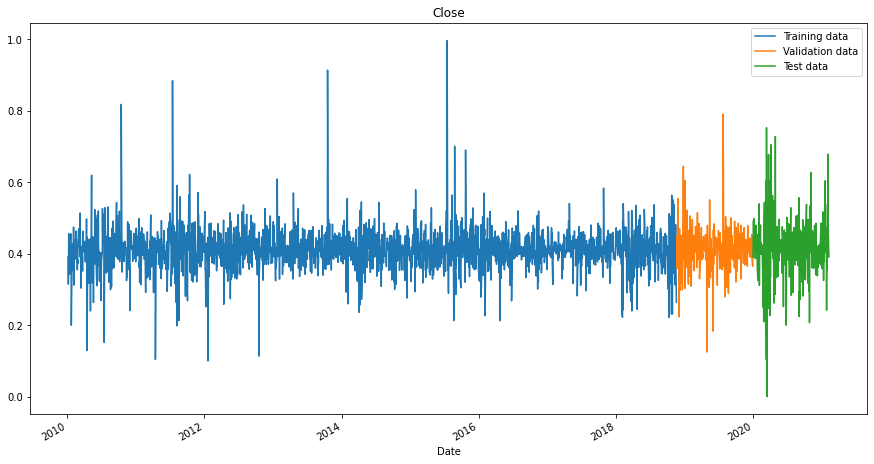

In [13]:
df_train['Close'].plot(figsize = (15,8), title='Close', label='Training data', legend=True)
df_val['Close'].plot(figsize = (15,8), title='Close', label='Validation data', legend=True)
df_test['Close'].plot(figsize = (15,8), title='Close', label='Test data', legend=True)
plt.show()

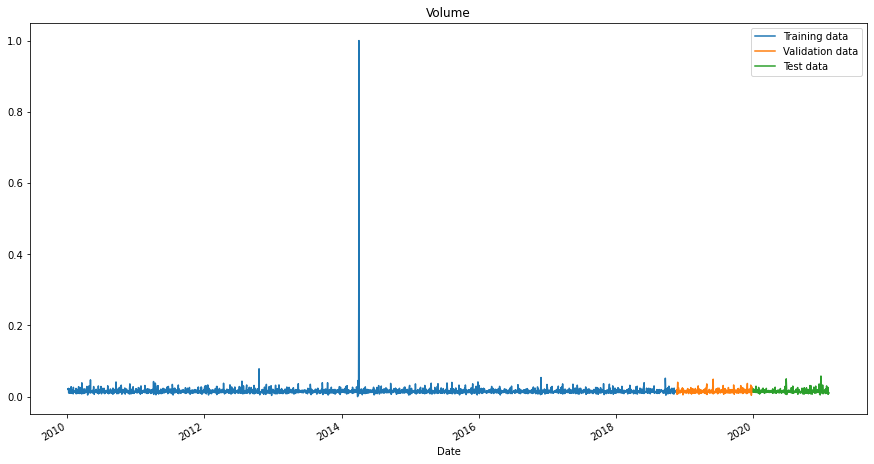

In [14]:
df_train['Volume'].plot(figsize = (15,8), title='Volume', label='Training data', legend=True)
df_val['Volume'].plot(figsize = (15,8), title='Volume', label='Validation data', legend=True)
df_test['Volume'].plot(figsize = (15,8), title='Volume', label='Test data', legend=True)
plt.show()

- Mar 27, 2014: 2002:1000 Stock Split
- Close price adjusted for splits.
- Adjusted close price adjusted for both dividends and splits.

In [15]:
df_train['Volume'].sort_values().tail()

Date
2018-09-21    0.051824
2016-11-28    0.053699
2012-10-18    0.078239
2014-04-02    0.267816
2014-04-03    1.000000
Name: Volume, dtype: float64

### Create chunks of training, validation and test data

In [16]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (2108, 128, 5) (2108,)
Validation set shape (151, 128, 5) (151,)
Testing set shape (151, 128, 5) (151,)


Lastly, the training, validation, and test sets are separated into individual sequences with a length of 128 days each. For each sequence day, the 4 price features (Open, High, Low, Close) and the Volume feature are present, resulting in 5 features per day. During a single training step, our Transformer model will receive 32 sequences (batch_size = 32) that are 128 days long (seq_len=128) and have 5 features per day as input.

## Time Embeddings

As the first step of our Transformer implementation, we have to consider how to encode the notion of time which is hidden in our stock prices into our model.

When processing time-series data, time is an essential feature. However, when processing time-series/sequential data with a Transformer, sequences are forwarded all at once through the Transformer architecture, making it difficult to extract temporal/sequential dependencies. Thus, Transformers that are used in combination with natural language data tend to utilize positional encoding to provide a notion of word order to the model. In detail, the positional encoding is a representation of a word’s value and its position in a sentence, allowing the Transformer to obtain knowledge about a sentence structure and word interdependencies. An example of positional encoding can be found when looking under the hood of the BERT model, which has achieved state-of-the-art performance for many language tasks.

- [2] BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding https://arxiv.org/abs/1810.04805

Similarly, a **Transformer requires a notion of time** when processing our stock prices. Without Time Embeddings, our Transformer would not receive any information about the temporal order of our stock prices. Hence, a stock price from 2020 can have the same influence on tomorrows’ price prediction as a price from the year 1990. And of course, this would be ludicrous.

## Time to Vector

In order to overcome a Transformer’s temporal indifferences, we will implement the approach described in the paper Time2Vec: Learning a Vector Representation of Time. The authors of the paper propose “a model-agnostic vector representation for time, called Time2Vec”. You can think of a vector representation just like a normal embedding layer that can be added to a neural network architecture to improve a model’s performance.

- [3] Time2Vec: Learning a Vector Representation of Time https://arxiv.org/abs/1907.05321

Boiling the paper down to its essentials, there are two main ideas to consider. 

1. The authors identified that a meaningful representation of time has to include both periodic and non-periodic patterns. An example of a periodic pattern is the weather that varies over different seasons. In contrast, an example of a non-periodic pattern would be a disease, which occurs with a high probability, the older a patient.

2. A time representation should have an invariance to time rescaling, meaning that the time representation is not affected by different time increments e.g. (days, hours or seconds) and long time horizons.

Combining the ideas of periodic and non-periodic patterns as well as the invariance to time rescaling we are presented by the following mathematical definition. No worries, it is easier than it looks and I’ll explain it in detail. 

### Time2Vector Keras implementation

we have discussed how the periodic and non-periodic components of our time vector work in theory, now we’ll implement them in code. In order for the time vector to be easily integrated in any kind of neural network architecture, we’ll define the vector as a Keras layer. Our custom Time2Vector Layer has two sub-functions `build()` and `call()`. 

In `build()` we initiate 4 matrices, 2 for $\omega$ and 2 for $\varphi$ since we need a $\omega$ and $\varphi$ matrix for both non-periodical (linear) and the periodical (sin) features.

After having initiated our 4 matrices we define the calculation steps that will be performed once the layer is called, hence the `call()` function.

The input which will be received by the Time2Vector layer has the following shape (batch_size, seq_len, 5) → (32, 128, 5). 
- The batch_size defines how many stock price sequences we want to feed into the model/layer at once. 
- The seq_len parameter determines the length of a single stock price sequence. 
- Lastly, the number 5 is derived from the fact that we have 5 features of the daily GOOG stock recording (Open price, High price, Low price, Close price, Volume).

The first calculation step excludes the Volume and **takes an average across the Open, High, Low, and Close prices**, resulting in the shape (batch_size, seq_len).

Next, we calculate the non-periodic **(linear) time feature** and expand the dimension by 1 again. (batch_size, seq_len, 1)

The same process is repeated for the **periodic time feature**, also resulting in the same matrix shape. (batch_size, seq_len, 1)

The last step that is needed to conclude the time vector calculation is **concatenating the linear and periodic time feature**. (batch_size, seq_len, 2)

Combining all steps into one Layer function the code looks as follows.

In [17]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        # takes an average across the Open, High, Low, and Close prices
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

## Transformer



In [18]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
        self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
        self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

In [19]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
        self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear   

In [20]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 

    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
        return config

## Model

In [21]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 7)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 7)       99114       concatenate[0][0]            

66/66 [==============================] - 121s 2s/step - loss: 0.0036 - mae: 0.0423 - mape: 10.8552 - val_loss: 0.0030 - val_mae: 0.0350 - val_mape: 8.8595

Epoch 00022: val_loss did not improve from 0.00293
Epoch 23/35
66/66 [==============================] - 115s 2s/step - loss: 0.0035 - mae: 0.0423 - mape: 10.9030 - val_loss: 0.0031 - val_mae: 0.0367 - val_mape: 9.1003

Epoch 00023: val_loss did not improve from 0.00293
Epoch 24/35
66/66 [==============================] - 115s 2s/step - loss: 0.0034 - mae: 0.0417 - mape: 10.6094 - val_loss: 0.0030 - val_mae: 0.0359 - val_mape: 9.3281

Epoch 00024: val_loss did not improve from 0.00293
Epoch 25/35
66/66 [==============================] - 116s 2s/step - loss: 0.0035 - mae: 0.0411 - mape: 10.8158 - val_loss: 0.0030 - val_mae: 0.0358 - val_mape: 8.9494

Epoch 00025: val_loss did not improve from 0.00293
Epoch 26/35
66/66 [==============================] - 115s 2s/step - loss: 0.0036 - mae: 0.0426 - mape: 10.9037 - val_loss: 0.0029 - val_

OSError: SavedModel file does not exist at: /content/Transformer+TimeEmbedding.hdf5/{saved_model.pbtxt|saved_model.pb}

In [22]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0032, MAE: 0.0383, MAPE: 10.1924
Validation Data - Loss: 0.0030, MAE: 0.0355, MAPE: 9.2040
Test Data - Loss: 0.0049, MAE: 0.0515, MAPE: 13.3476


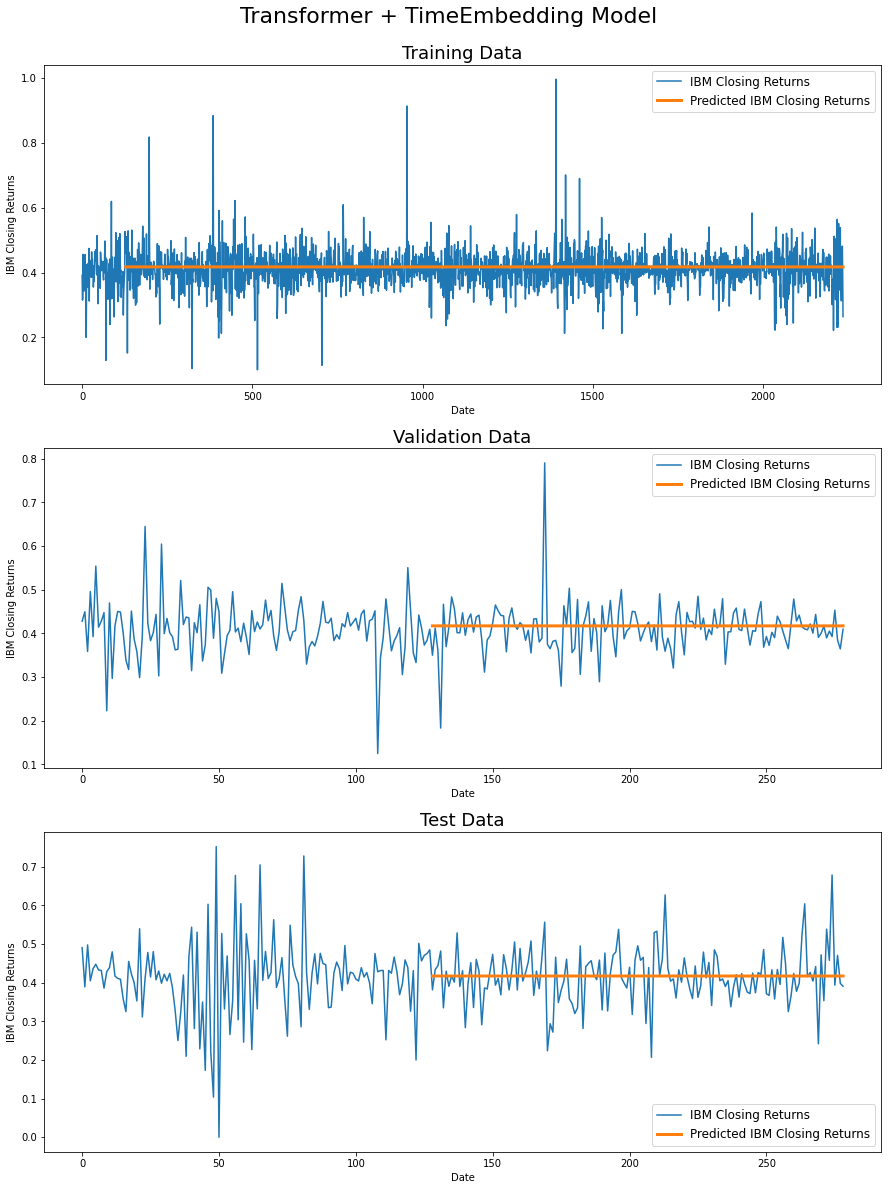

In [23]:
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [24]:
## Model metrics

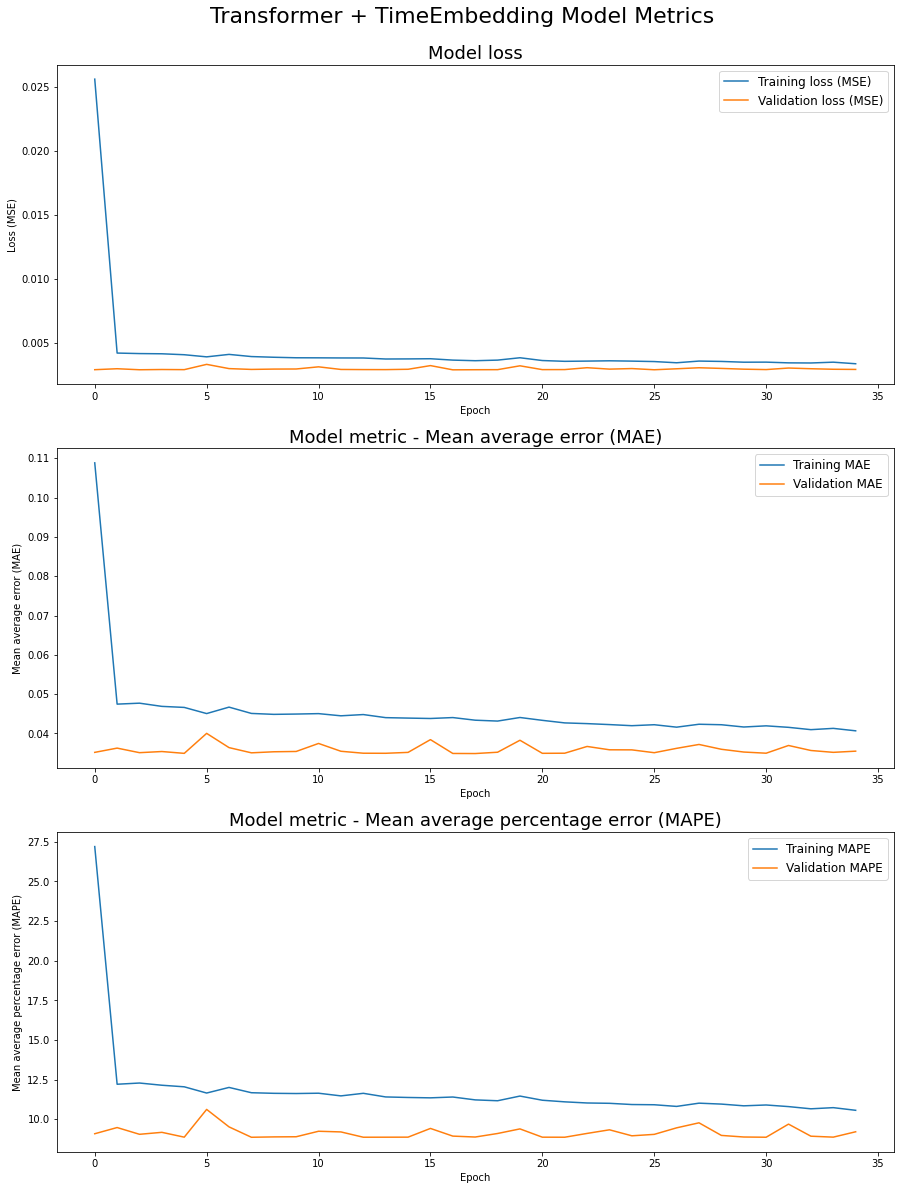

In [25]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [26]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Moving Average
### Moving Average - Load IBM data again, to apply rolling window


In [27]:
df = pd.read_csv(path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,Date,Open,High,Low,Close,Volume
9,2010-01-15,300.734271,302.626685,296.423431,299.061539,9699339.9
10,2010-01-19,298.455313,300.679483,294.034885,297.112344,10173209.4
11,2010-01-20,296.403006,298.594299,291.731021,294.941483,10222593.8
12,2010-01-21,294.289926,296.649588,290.031891,293.682202,10690139.8
13,2010-01-22,292.053311,294.686945,287.153180,291.485934,10767649.2


### Moving Average - Plot daily IBM closing prices and volume

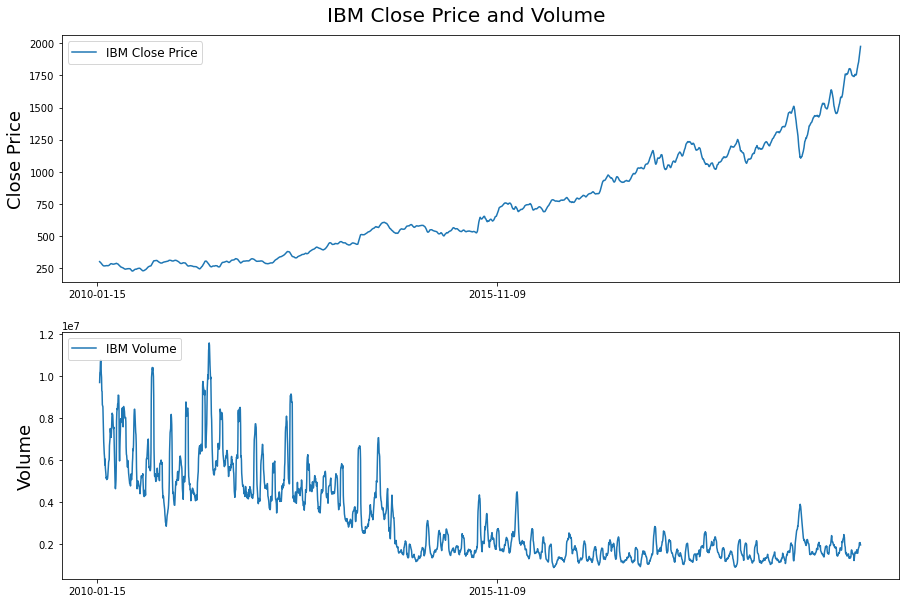

In [28]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

### Moving Average - Calculate normalized percentage change for all columns

In [29]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (2228, 5)
Validation data shape: (279, 5)
Test data shape: (278, 5)


/Users/bochmann/Library/Caches/pypoetry/virtualenvs/pmf-NPctrmOt-py3.7/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Open,High,Low,Close,Volume
10,0.339387,0.360767,0.330416,0.359209,0.459761
11,0.352503,0.351409,0.334576,0.344462,0.408229
12,0.347779,0.359299,0.372171,0.401236,0.456108
13,0.338975,0.357371,0.295502,0.341249,0.411036
14,0.336261,0.312401,0.307230,0.282914,0.395898


### Moving Average - Plot daily changes of close price and volume

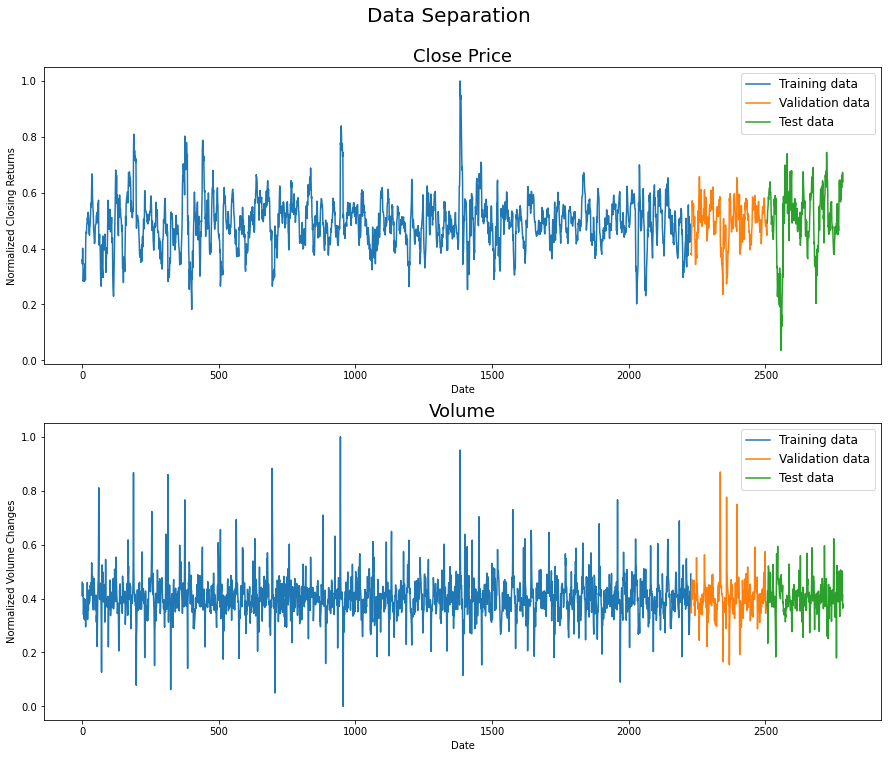

In [30]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

### Moving Average - Create chunks of training, validation, and test data

In [31]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2100, 128, 5) (2100,)
(151, 128, 5) (151,)


### Moving Average - Model

In [32]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time2_vector_1 (Time2Vector)    (None, 128, 2)       512         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 7)       0           input_2[0][0]                    
                                                                 time2_vector_1[0][0]             
__________________________________________________________________________________________________
transformer_encoder_3 (Transfor (None, 128, 7)       99114       concatenate_1[0][0]        


Epoch 00022: val_loss did not improve from 0.00444
Epoch 23/35
66/66 [==============================] - 139s 2s/step - loss: 0.0086 - mae: 0.0701 - mape: 15.0524 - val_loss: 0.0045 - val_mae: 0.0515 - val_mape: 11.3316

Epoch 00023: val_loss did not improve from 0.00444
Epoch 24/35
66/66 [==============================] - 140s 2s/step - loss: 0.0084 - mae: 0.0687 - mape: 15.0666 - val_loss: 0.0048 - val_mae: 0.0563 - val_mape: 11.7051

Epoch 00024: val_loss did not improve from 0.00444
Epoch 25/35
66/66 [==============================] - 143s 2s/step - loss: 0.0081 - mae: 0.0681 - mape: 14.6115 - val_loss: 0.0045 - val_mae: 0.0524 - val_mape: 11.2393

Epoch 00025: val_loss did not improve from 0.00444
Epoch 26/35
66/66 [==============================] - 160s 2s/step - loss: 0.0078 - mae: 0.0671 - mape: 14.5424 - val_loss: 0.0046 - val_mae: 0.0534 - val_mape: 11.3333

Epoch 00026: val_loss did not improve from 0.00444
Epoch 27/35
66/66 [==============================] - 143s 2s/step - 

OSError: SavedModel file does not exist at: /content/Transformer+TimeEmbedding.hdf5/{saved_model.pbtxt|saved_model.pb}

### Moving Average - Model metrics

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)